# Compose Background Removed Image with DallE2 Background

# Packages & Credential

In [2]:
import requests
import json
from PIL import Image
import logging
from openai import cli
import matplotlib.pyplot as plt
import requests
import os
import time
import io
import azure.ai.vision as visionsdk
import openai
from io import BytesIO

In [3]:

openai.api_type = 'azure'
openai.api_base = os.environ.get('openai.api_base')
openai.api_version = os.environ.get('openai.api_version')
openai.api_key = os.environ.get('openai.api_key')
vision_base= os.environ.get('cognitive_endpoint')
vision_key= os.environ.get('cognitive_key')

# Background Removed Image

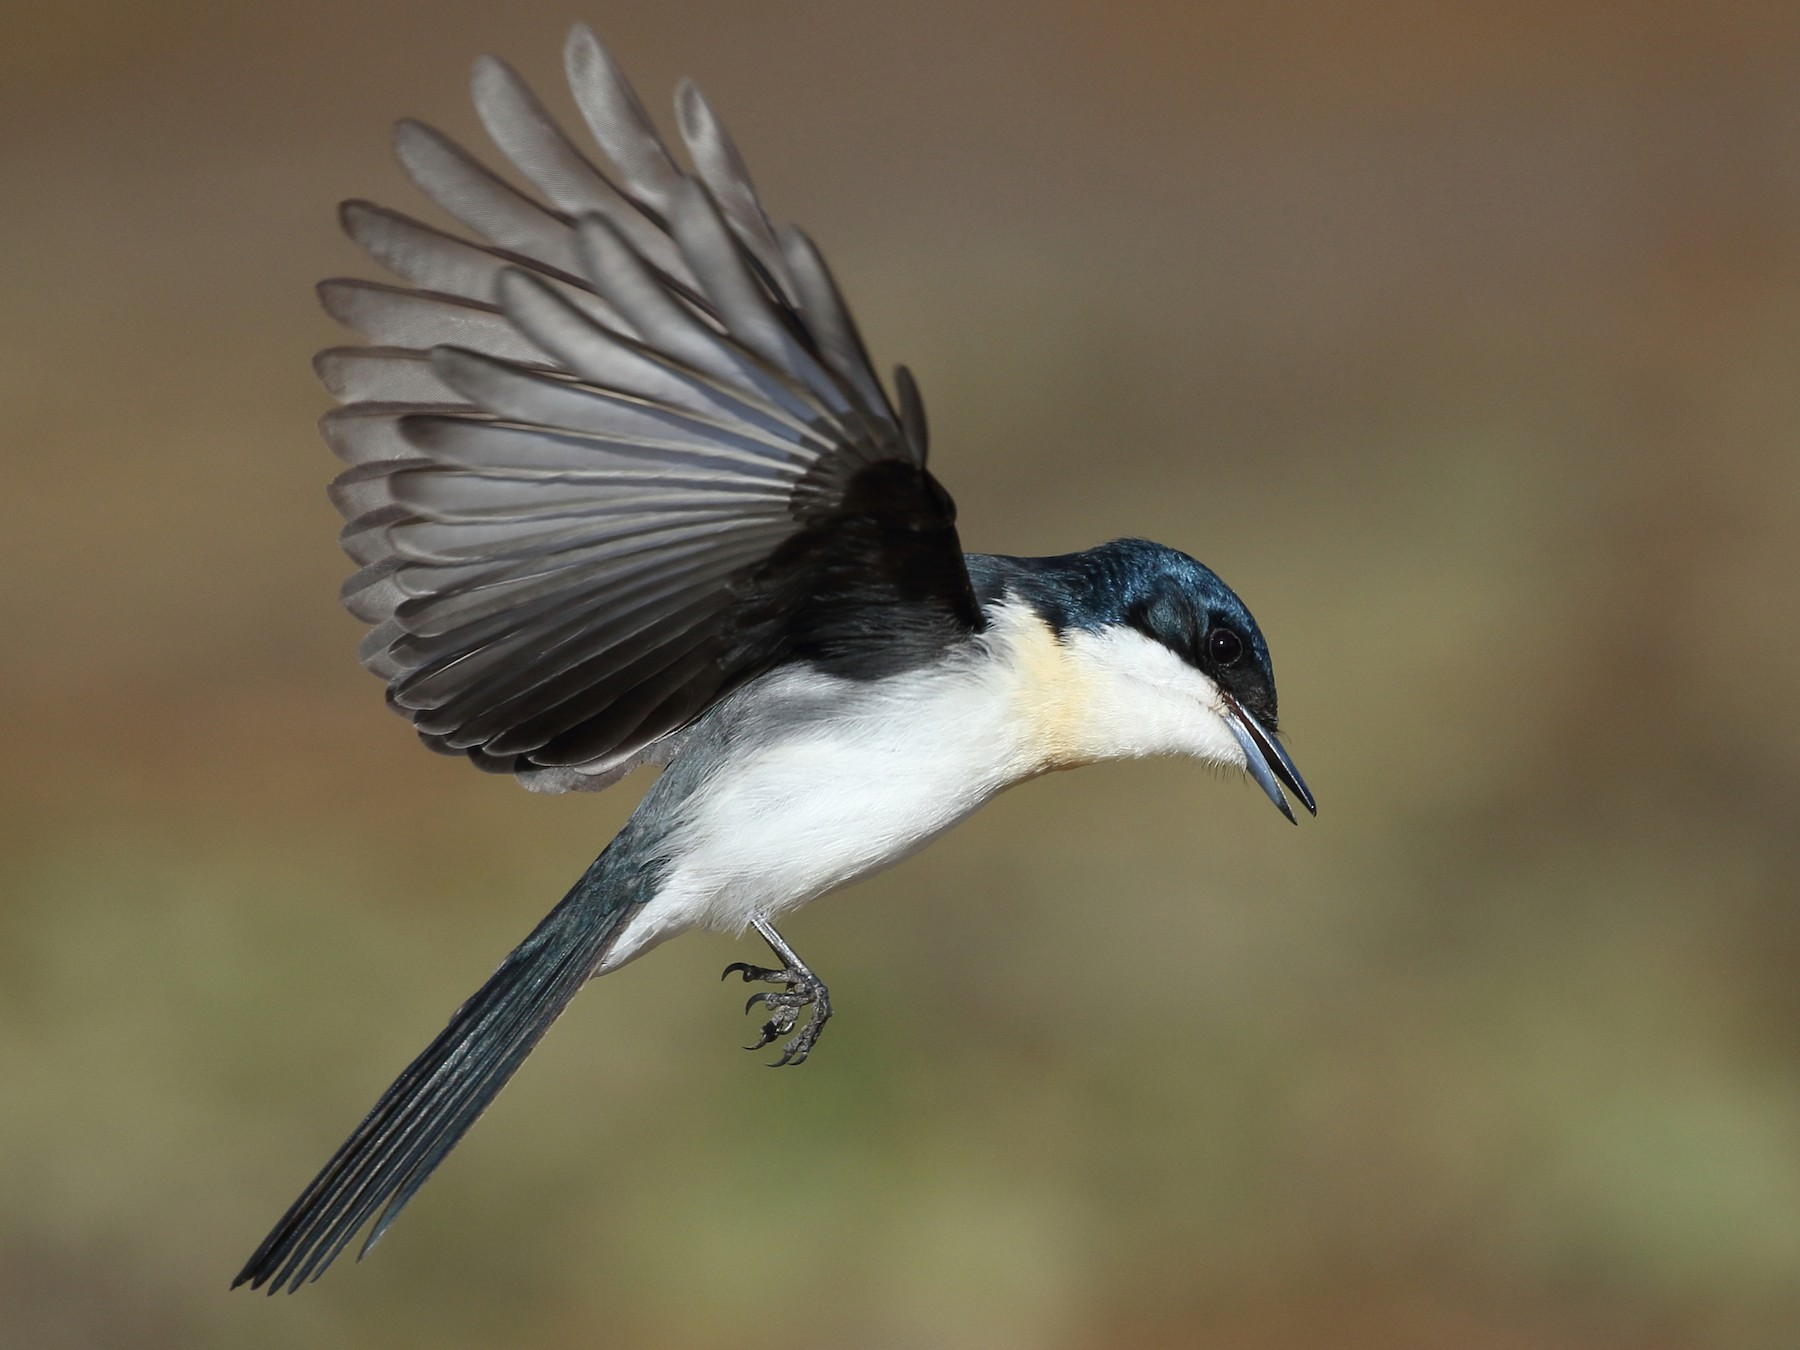

In [4]:
response = requests.get(r'https://cdn.download.ams.birds.cornell.edu/api/v1/asset/125818161/1800')

# Load the image data from the response content
img_data = response.content

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

display(img)

In [8]:
def background_removal(image_url):
  url = vision_background_base
  image = image_url

  payload = json.dumps({
    "url": image
  })
  headers = {
    'Content-Type': 'application/json',
    'Ocp-Apim-Subscription-Key': vision_key
  }

  response = requests.request("POST", url, headers=headers, data=payload)
  removal = response.content
  # Save the response content to a file

  removal = response.content
  return removal


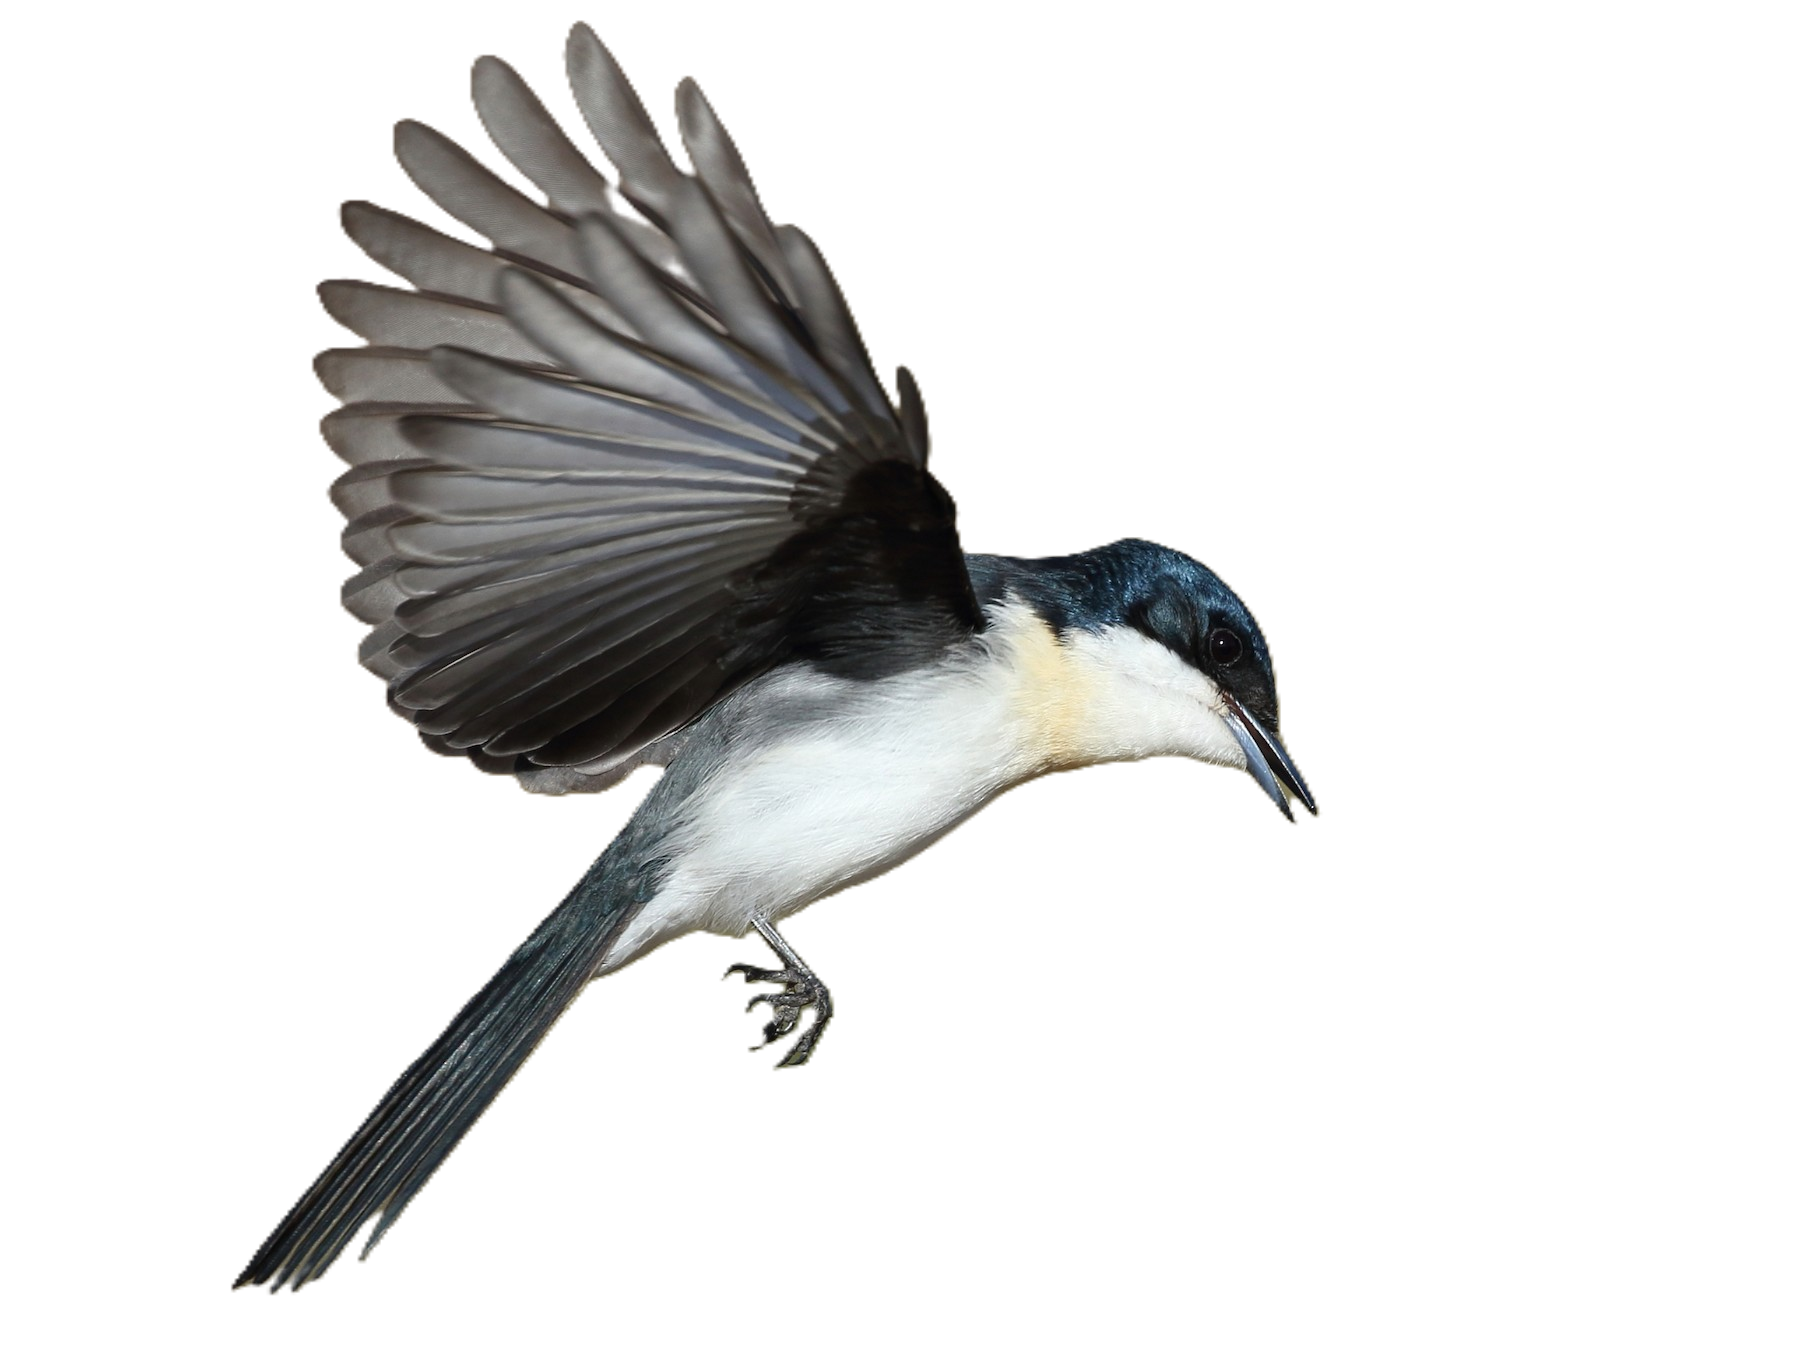

In [9]:
image_url = "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/125818161/1800"

removal=background_removal(image_url)

# Create a PIL Image object from the image data
img = Image.open(BytesIO(removal))

display(img)

# Background using DallE2

In [10]:
def get_image(prompt):
    api_version = '2022-08-03-preview'
    url = "{}dalle/text-to-image?api-version={}".format(openai.api_base, api_version)
    headers = {"api-key": openai.api_key, "Content-Type": "application/json"}
    body = {
        "caption": prompt,
        "resolution": "512x512"
    }

    max_tries = 8
    tries = 0
    total_wait = 30
    time_waited = 0

    while tries < max_tries and time_waited < total_wait:
        submission = requests.post(url, headers=headers, json=body)
        if submission.status_code != 202:
            retry_after = int(submission.headers.get('Retry-After', 0))
            time.sleep(retry_after+2)
            logging.info("failed: DallE2 Request failed. retry")
            print("failed: DallE2 Request failed. retry")
            continue
        else:
            try:
                operation_location = submission.headers['Operation-Location']
            except KeyError:
                logging.info("failed: Operation-Location header missing!!!")
                print("failed: Operation-Location header missing!!!")
                time.sleep(1)
                continue
            
            start_time = time.time()
            while time.time() - start_time < total_wait - time_waited:
                response = requests.get(operation_location, headers=headers)
                if response.status_code == 200:
                    status = response.json()['status']
                    if status == "Succeeded":
                        logging.info("succeeded...")
                        print("succeeded...")
                        return response.json()['result']['contentUrl']
                    elif status == "Running":
                        retry_after = int(response.headers.get('Retry-After', 0))
                        time.sleep(retry_after)
                    else:
                        logging.info("failed: status = " + status)
                        print("failed: status = " + status)
                        break
                else:
                    logging.info("failed: response code = " + str(response.status_code))
                    print("failed: response code = " + str(response.status_code))
                    time.sleep(1)
                    break
                time_waited = time.time() - start_time
                tries += 1
            if status == "Succeeded":
                break
            else:
                tries += 1
    return None

succeeded...


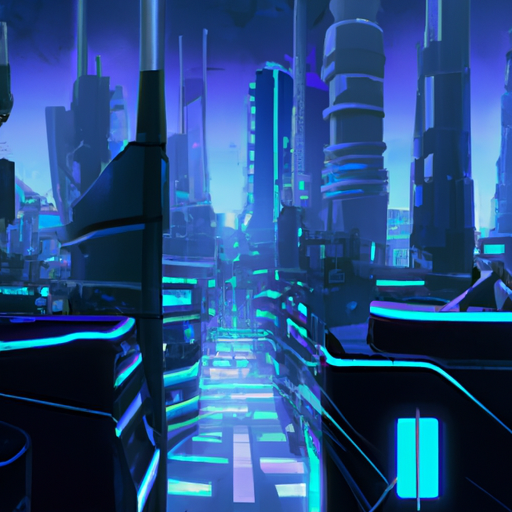

In [11]:
prompt = "a metropolitan city, Cyberpunk, Long shot"
result= get_image(prompt)
response = requests.get(result)

# Load the image data from the response content
img_data = response.content

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

display(img)

# Compose 2 Images

#### With the help of the Pillow library's Image module, it is possible to merge two images together. These images would typically consist of a background-removed image and a background image generated by DallE2.

In [12]:
def compose_image(removal, result, size):

    image_file = io.BytesIO(removal)
    front_img = Image.open(image_file)

    response = requests.get(result)
    back_img = Image.open(BytesIO(response.content))

    # Resize the front image while maintaining its aspect ratio
    front_img.thumbnail((size,size))

    # Find the size of the larger image
    width = max(front_img.width, back_img.width)
    height = max(front_img.height, back_img.height)

    # Create a new empty image with the size of the larger image
    composed_img = Image.new("RGBA", (width, height))

    # Paste the back image onto the composed image with an offset
    back_offset = ((width - back_img.width) // 2, (height - back_img.height) // 2)
    composed_img.paste(back_img, back_offset)

    # Paste the front image onto the composed image with an offset
    front_offset = ((width - front_img.width) // 2, (height - front_img.height) // 2)
    composed_img.paste(front_img, front_offset, front_img)

    return composed_img

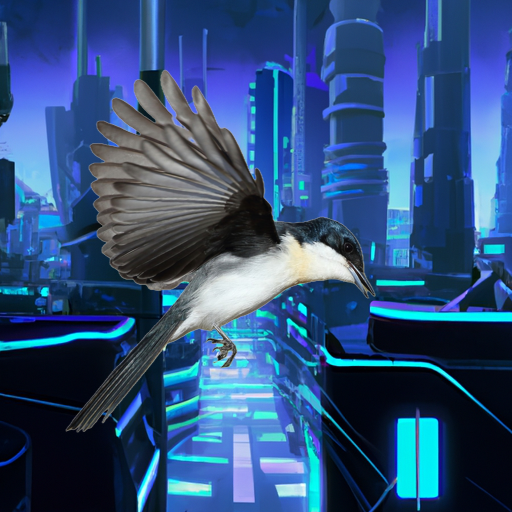

In [14]:
size = 512
composed_img= compose_image(removal, result, size)
display(composed_img)